In [629]:
# Author: Enes Saçak
# Number: 150210014
# Project: 3

In [630]:
import numpy as np
import cv2
import heapq
from PIL import Image
import matplotlib.pyplot as plt

In [631]:
N = 2
Q = 10
host_path = 'baboon.bmp'
host_image = Image.open(host_path).convert('L')
sz = host_image.size[0]
sz = sz - (sz % N)
host_image = host_image.resize((sz, sz))
host_image = np.array(host_image)
host_image = (host_image).astype(int)
watermark_path = 'icon1.bmp'
watermark_image = Image.open(watermark_path).convert('1')
if (watermark_image.size[0] > (sz // N)):
    watermark_image = watermark_image.resize((sz // N, sz // N))
watermark_image = np.array(watermark_image)
watermark_image = (watermark_image).astype(int)

In [632]:
def partition_image(image, block_size):
    height, width = image.shape[:2]
    blocks = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = image[y:y+block_size, x:x+block_size]
            blocks.append(block)
    return blocks

In [633]:
original_blocks = partition_image(host_image, N)

In [634]:
# def QR_Decomposition(M):
#     n = len(M) 
#     preComp = [0 for i in range(n)]
#     sum = np.int64(0)
#     for i in range(n):
#         sum += M[i][0] * M[i][0]
#     preComp[0] = sum
#     Q = [[M[i][j] for j in range(n)] for i in range(n)]
#     for i in range(1, n): # O(n^3) complexity
#         for k in range(i-1, -1, -1):
#             if (preComp[k] == 0): # cannot be factorized since having no independent vectors
#                 continue
#             sum = np.int64(0)
#             for j in range(n):
#                 sum += M[j][i] * Q[j][k]
#             sum /= preComp[k]
#             for j in range(n):
#                 Q[j][i] -= Q[j][k] * sum
#         sum = np.int64(0)
#         for k in range(n):
#             sum += Q[k][i] * Q[k][i]
#         preComp[i] = sum

#     for i in range(n):
#         for j in range(n):
#             if (preComp[j] != 0):
#                 Q[i][j] /= np.sqrt(preComp[j])
#     Q = np.array(Q)
#     R = np.transpose(Q) @ M
#     return Q, R

In [635]:
def EIG(M, max_iter=100, atol=1e-9):
    A = np.copy(M)
    QQ = np.eye(len(M)) # initial identity matrix before iteration
    for _ in range(max_iter):
        Q, R = np.linalg.qr(A)
        A = R @ Q
        QQ = QQ @ Q
        if np.sum(np.abs(A - np.diag(np.diagonal(A)))) < atol:
            break
    return np.diag(A), QQ

In [636]:
def SVD(M, max_iter=100, atol=1e-9):
    eigenvalues, V = EIG(np.transpose(M) @ M)
    Sigma = np.sqrt(np.maximum(eigenvalues, 0))
    max_heap = []

    for i, value in enumerate(Sigma):
        heapq.heappush(max_heap, (-value, i))

    sorted_indices = [heapq.heappop(max_heap)[1] for _ in range(len(max_heap))]
    Sigma = Sigma[sorted_indices]
    V = V[:, sorted_indices]
    U = M @ V @ np.linalg.pinv(np.diag(Sigma))
    return U, Sigma, np.transpose(V)

In [637]:
def embed(original_blocks, watermark_image, Q, block_size):
    height, width = watermark_image.shape[:2]
    modified_blocks = np.copy(original_blocks)

    block = 0
    for y in range(height):
        for x in range(width):
            # if (block % 100 == 0):
            #     print('dbg: ', block)
            # U, D, VT = np.linalg.svd(original_blocks[block], full_matrices=True)
            U, D, VT = SVD(original_blocks[block])
            new_D = np.copy(D)
            Z = new_D[0] % Q
            if (watermark_image[y][x] == 0):
                if (Z < 3 * Q/4): new_D[0] += Q/4 - Z
                else: new_D[0] += 5 * Q/4 - Z
            else:
                if (Z < Q/4): new_D[0] -= Q/4 - Z
                else: new_D[0] += 3 * Q/4 - Z
            new_D = np.diag(np.squeeze(new_D))
            modified_blocks[block] = U @ new_D @ VT
            block += 1

    return modified_blocks

In [638]:
def unite(blocks, block_size):
    N = int(np.sqrt(len(blocks))) * block_size
    united_matrix = [[0 for _ in range(N)] for _ in range(N)]

    for i in range(N):
        for j in range(N):
            block = i // block_size * int(np.sqrt(len(blocks))) + j // block_size
            B_i, B_j = i % block_size, j % block_size
            united_matrix[i][j] = blocks[block][B_i, B_j]

    return united_matrix

In [639]:
embedded_blocks = embed(original_blocks, watermark_image, Q, N)
embedded_image = Image.fromarray(np.array(unite((embedded_blocks), N)).astype('uint8'))
embedded_image.save("embedded_image.png")

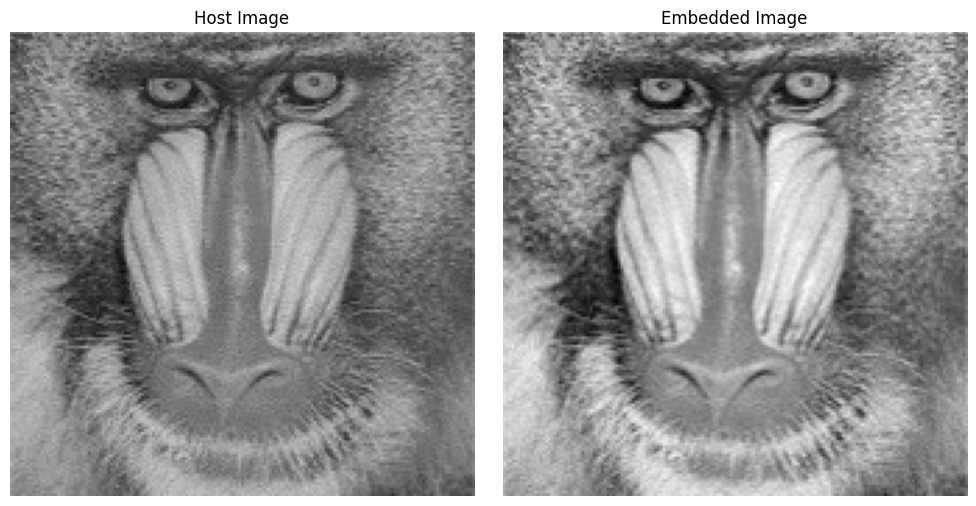

In [640]:
image1 = Image.open(host_path)
image2 = Image.open('embedded_image.png')
title1 = "Host Image"
title2 = "Embedded Image"
image1_gray = np.array(image1)
image2_gray = np.array(image2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image1_gray, cmap='gray')
axs[0].set_title(title1)
axs[0].axis('off')
axs[1].imshow(image2_gray, cmap='gray')
axs[1].set_title(title2)
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [641]:
def extract(embedded_blocks, Q, wm):

    height, width = wm.shape[:2]
    block = 0
    watermark_image = [[0 for _ in range(width)] for _ in range(height)]

    for i in range(height):
        for j in range(width):
            # U, D, VT = np.linalg.svd(embedded_blocks[block], full_matrices=True)
            U, D, VT = SVD(embedded_blocks[block])
            Z = D[0] % Q
            if (Z < Q/2):
                watermark_image[i][j] = 0
            else:
                watermark_image[i][j] = 255
            block += 1

    return watermark_image

In [642]:
extracted_image = Image.fromarray(np.array(extract((embedded_blocks), Q, watermark_image)).astype('uint8'))
extracted_image.save("extracted_image.png")

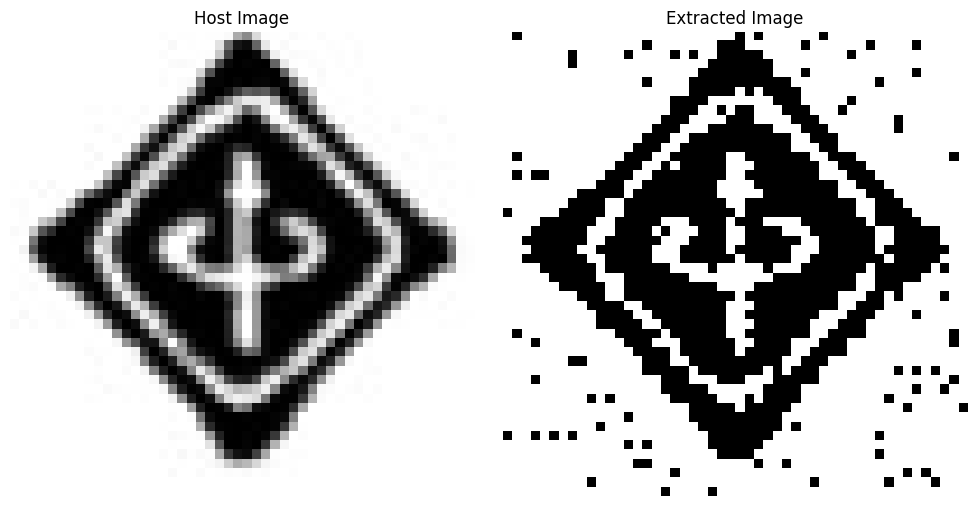

In [643]:
image1 = Image.open(watermark_path)
image2 = Image.open('extracted_image.png')
title1 = "Host Image"
title2 = "Extracted Image"
image1_gray = np.array(image1)
image2_gray = np.array(image2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image1_gray, cmap='gray')
axs[0].set_title(title1)
axs[0].axis('off')
axs[1].imshow(image2_gray, cmap='gray')
axs[1].set_title(title2)
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [644]:
def PSNR(original, extracted): # calculation method taken from geeksforgeeks.com
    mse = np.mean((original - extracted) ** 2) 
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [645]:
diff = PSNR(host_image, embedded_image)
print("PSNR: ", diff)

PSNR:  50.2271990067928
